# Mount drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Keras, numpy and matplotlib Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
# from google.colab.patches import cv2_imshow
from tensorflow import keras
from keras import optimizers
from keras.optimizers import schedules

# Create custom test set

In [ ]:
import os
import cv2
def get_test_data(folder="/content/drive/MyDrive/HTP_dataset/dataset/data_set_5/test_1"):
  all_test_data = []
  listdir = os.listdir(folder)
  for file in listdir:
    img = cv2.imread(f'{folder}/{file}')
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)

    all_test_data.append(img)
  return all_test_data

# Create <b>train</b> and <b>validation</b> sets

In [ ]:
train = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/HTP_dataset/dataset/data_set_5/train', image_size=(256, 256))
val = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/HTP_dataset/dataset/data_set_5/val', image_size=(256, 256))


Found 1710 files belonging to 3 classes.
Found 188 files belonging to 3 classes.


# Call get_test_data() method to create test set

In [ ]:
test = get_test_data()

In [ ]:
train.class_names

['house', 'person', 'tree']

In [ ]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])

In [ ]:
normalizeds = tf.keras.Sequential([
  layers.Normalization(mean=0.4, variance=0.2)
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False, normalize=True):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)

  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
  if normalize:
    ds = ds.map(lambda x, y: (normalizeds(x), y), 
                num_parallel_calls=AUTOTUNE)
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train, shuffle=True, augment=True)
val_ds = prepare(val)

# ResNet50

In [ ]:
baseModelResNet50 = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3), # specify input shape
    include_top=False # do not include the top layer
)

In [ ]:
headModel50 = baseModelResNet50.output
headModel50 = keras.layers.GlobalAveragePooling2D()(headModel50)
headModel50 = keras.layers.Dropout(0.2)(headModel50)  # Regularize with dropout
outputs = keras.layers.Dense(3, activation="softmax")(headModel50) # set dense layer to classify output three classifications

In [ ]:
modelResNet50 = keras.Model(baseModelResNet50.inputs, outputs)

# Set optimizer, learning rate scheduler, loss and metrics

In [ ]:
baseModelResNet50.trainable = True
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,# Low learning rate
    decay_steps=10000, # decay every 10000 steps with a base of 0.9
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)

modelResNet50.compile(
    optimizer=opt,  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

epochs = 10
history_model1 = modelResNet50.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 221s 874ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.3194 - val_sparse_categorical_accuracy: 0.9149
Epoch 2/10
54/54 [==============================] - 53s 446ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.2150 - val_sparse_categorical_accuracy: 0.9415
Epoch 3/10
54/54 [==============================] - 52s 428ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9362
Epoch 4/10
54/54 [==============================] - 51s 425ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.1350 - val_sparse_categorical_accuracy: 0.9574
Epoch 5/10
54/54 [==============================] - 51s 426ms/step - loss: 0.0736 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.2526 - val_sparse_categorical_accuracy: 0.9415
Epoch 6/10
54/54 [==============================] - 55s 430ms/step - loss: 0.0723 - sparse_cat

# Save model

In [ ]:
modelResNet50.save('/content/drive/MyDrive/KerasModels3/modelResNet50')

## plot accuracy of ResNet50

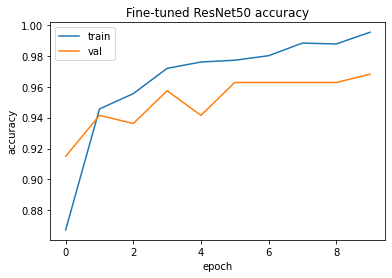

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_model1.history['sparse_categorical_accuracy'])
plt.plot(history_model1.history['val_sparse_categorical_accuracy'])
plt.title('Fine-tuned ResNet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## plot loss of ResNet50

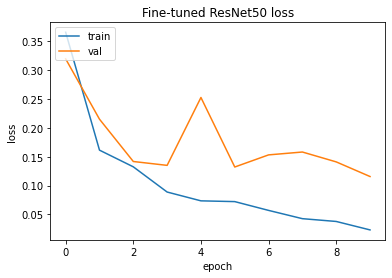

In [ ]:
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Fine-tuned ResNet50 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ResNet101

In [ ]:
baseModelResNet101 = keras.applications.ResNet101V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False # dont include top layer
)

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
headModel101 = baseModelResNet101.output
headModel101 = keras.layers.GlobalAveragePooling2D()(headModel101)
headModel101 = keras.layers.Dropout(0.2)(headModel101)  # Regularize with dropout
outputs = keras.layers.Dense(3, activation="softmax")(headModel101)

In [ ]:
modelResNet101 = keras.Model(baseModelResNet101.inputs, outputs)

In [ ]:
baseModelResNet101.trainable = True
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)

modelResNet101.compile(
    optimizer=opt,  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

epochs = 10
history_ResNet101 = modelResNet101.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 76s 740ms/step - loss: 0.3583 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.2014 - val_sparse_categorical_accuracy: 0.9362
Epoch 2/10
54/54 [==============================] - 67s 715ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.1962 - val_sparse_categorical_accuracy: 0.9309
Epoch 3/10
54/54 [==============================] - 67s 719ms/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.1283 - val_sparse_categorical_accuracy: 0.9574
Epoch 4/10
54/54 [==============================] - 66s 712ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.0928 - val_sparse_categorical_accuracy: 0.9574
Epoch 5/10
54/54 [==============================] - 67s 715ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.1178 - val_sparse_categorical_accuracy: 0.9628
Epoch 6/10
54/54 [==============================] - 67s 716ms/step - loss: 0.0499 - sparse_cate

### save model

In [ ]:
modelResNet101.save('/content/drive/MyDrive/KerasModels3/modelResNet101')

## Plot Accuracy of ResNet101

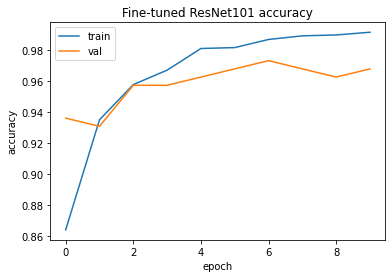

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_ResNet101.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet101.history['val_sparse_categorical_accuracy'])
plt.title('Fine-tuned ResNet101 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Plot the loss of ResNet101 

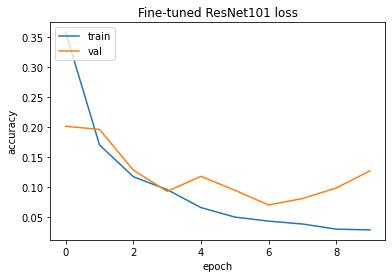

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_ResNet101.history['loss'])
plt.plot(history_ResNet101.history['val_loss'])
plt.title('Fine-tuned ResNet101 loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ResNet152

In [ ]:
baseModel152 = keras.applications.ResNet152(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False
    )

234698864/234698864 [==============================] - 3s 0us/step


In [ ]:
headModel = baseModel152.output
headModel = keras.layers.GlobalAveragePooling2D()(headModel)
headModel = keras.layers.Dropout(0.2)(headModel)  # Regularize with dropout
outputs = keras.layers.Dense(3, activation="softmax")(headModel)

In [ ]:
modelResNet152 = keras.Model(baseModel152.inputs, outputs)

In [ ]:
baseModel152.trainable = True
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)
modelResNet152.compile(
    optimizer=opt,  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

epochs = 10
history_modelResNet152 = modelResNet152.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 99s 1s/step - loss: 0.3874 - sparse_categorical_accuracy: 0.8567 - val_loss: 1.0813 - val_sparse_categorical_accuracy: 0.4628
Epoch 2/10
54/54 [==============================] - 85s 1s/step - loss: 0.2068 - sparse_categorical_accuracy: 0.9222 - val_loss: 1.3610 - val_sparse_categorical_accuracy: 0.3936
Epoch 3/10
54/54 [==============================] - 83s 1s/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9585 - val_loss: 1.1129 - val_sparse_categorical_accuracy: 0.4202
Epoch 4/10
54/54 [==============================] - 85s 1s/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9643 - val_loss: 1.0830 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
54/54 [==============================] - 84s 1s/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.9389 - val_sparse_categorical_accuracy: 0.6064
Epoch 6/10
54/54 [==============================] - 83s 1s/step - loss: 0.0696 - sparse_categorical_accuracy: 

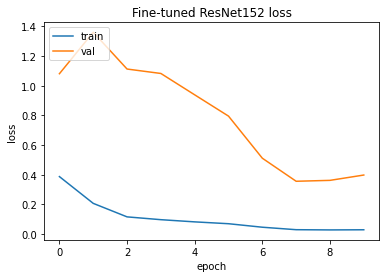

In [ ]:
plt.plot(history_modelResNet152.history['loss'])
plt.plot(history_modelResNet152.history['val_loss'])
plt.title('Fine-tuned ResNet152 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

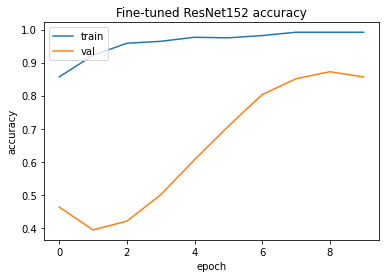

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_modelResNet152.history['sparse_categorical_accuracy'])
plt.plot(history_modelResNet152.history['val_sparse_categorical_accuracy'])
plt.title('Fine-tuned ResNet152 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### save model

In [ ]:
modelResNet152.save('/content/drive/MyDrive/KerasModels3/modelResNet152')

### Load models

### Prediction of fine-tuned ResNet50

In [ ]:
reconstructed_model_resnet50 = keras.models.load_model("/content/drive/MyDrive/KerasModels3/modelResNet50")

1/1 [==============================] - 0s 22ms/step


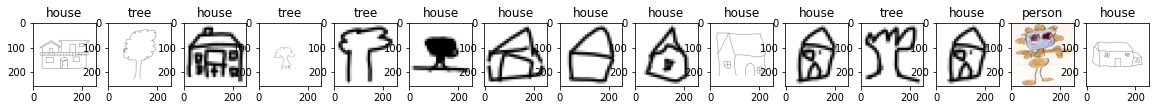

In [ ]:
from tkinter import Y
import cv2
import random
imgs = []
clas = []
ncols = 15
fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
for i in range(ncols):
    index = random.randint(0, len(test)-1)
    yhat = reconstructed_model_resnet50.predict(np.expand_dims(test[index]/255, 0))
    imgs.append(test[index])
    y_pred =[np.argmax(yi) for yi in yhat]
    if y_pred[0] == 0:
        ax[i].set_title("house")
    elif y_pred[0] == 1:
        ax[i].set_title("person")
    elif y_pred[0] == 2:
        ax[i].set_title("tree")
    ax[i].imshow(test[index], cmap="gray")

### Prediction of fine-tuned ResNet101

In [ ]:
reconstructed_model_resnet101 = keras.models.load_model("/content/drive/MyDrive/KerasModels3/modelResNet101")

1/1 [==============================] - 0s 31ms/step


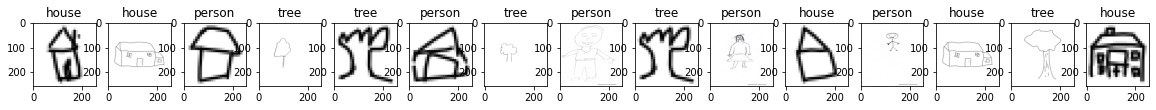

In [ ]:
from tkinter import Y
import cv2
import random
imgs = []
clas = []
ncols = 15
fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
for i in range(ncols):
    index = random.randint(0, len(test)-1)
    yhat = reconstructed_model_resnet101.predict(np.expand_dims(test[index]/255, 0))
    imgs.append(test[index])
    y_pred =[np.argmax(yi) for yi in yhat]
    if y_pred[0] == 0:
        ax[i].set_title("house")
    elif y_pred[0] == 1:
        ax[i].set_title("person")
    elif y_pred[0] == 2:
        ax[i].set_title("tree")
    ax[i].imshow(test[index], cmap="gray")

### Prediction of fine-tuned ResNet152

In [ ]:
reconstructed_model_resnet152 = keras.models.load_model("/content/drive/MyDrive/KerasModels3/modelResNet152")

1/1 [==============================] - 0s 35ms/step


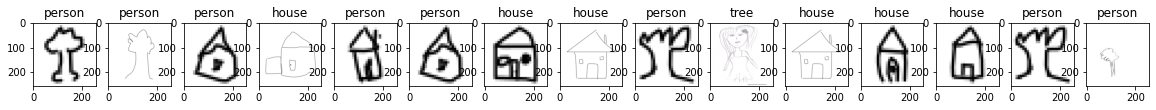

In [ ]:
from tkinter import Y
import cv2
import random
imgs = []
clas = []
ncols = 15
fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
for i in range(ncols):
    index = random.randint(0, len(test)-1)
    yhat = reconstructed_model_resnet152.predict(np.expand_dims(test[index]/255, 0))
    imgs.append(test[index])
    y_pred =[np.argmax(yi) for yi in yhat]
    if y_pred[0] == 0:
        ax[i].set_title("house")
    elif y_pred[0] == 1:
        ax[i].set_title("person")
    elif y_pred[0] == 2:
        ax[i].set_title("tree")
    ax[i].imshow(test[index], cmap="gray")